# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

Three dimensions!

## The Grizzly Bear Problem

In 1996 and 1997 Mowat and Strobeck deployed bear traps in locations in British Columbia and Alberta, in an effort to estimate the population of grizzly bears.  They describe the experiment in "[Estimating Population Size of Grizzly Bears Using Hair Capture, DNA Profiling, and Mark-Recapture Analysis](https://www.researchgate.net/publication/229195465_Estimating_Population_Size_of_Grizzly_Bears_Using_Hair_Capture_DNA_Profiling_and_Mark-Recapture_Analysis)"

The "trap" consists of  a lure and several strands of barbed wire intended to capture samples of hair from bears that visit the lure.  Using the hair samples, the researchers use DNA analysis to identify individual bears.

During the first session, on June 29, 1996, the researchers deployed traps at 76 sites.  Returning 10 days later, they obtained 1043 hair samples and identified 23 different bears.  During a second 10-day session they obtained 1191 samples from 19 different bears, where 4 of the 19 were from bears they had identified in the first batch.

To estimate the population of bears from this data, we need a model for the probability that each bear will be observed during each session.  As a starting place, we'll make the simplest assumption, that every bear in the population has the same (unknown) probability of being sampled during each round.

With these assumptions we can compute the probability of the data for a range of possible populations.

As an example, let's suppose that the actual population of bears is 200.

After the first session, 23 of the 200 bears have been identified.
During the second session, if we choose 19 bears at random, what is the probability that 4 of them were previously identified?

I'll define

* N: actual (unknown) population size, 200.

* K: number of bears identified in the first session, 23.

* n: number of bears observed in the second session, 19 in the example.

* k: the number of bears in the second session that had previously been identified, 4.

For given values of N, K, and n, the distribution of k is described by the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution):

$PMF(k) = {K \choose k}{N-K \choose n-k}/{N \choose n}$

To understand why, consider: 

* The denominator, ${ N \choose n}$, is the number of subsets of $n$ we could choose from a population of $N$ bears.

* The numerator is the number of subsets that contain $k$ bears from the previously identified $K$ and $n-k$ from the previously unseen $N-K$.

SciPy provides `hypergeom`, which we can use to compute this PMF.

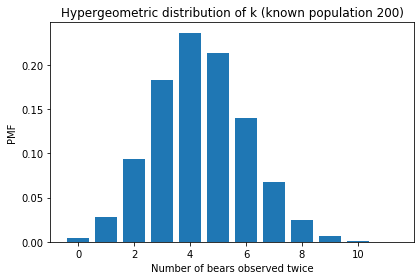

In [121]:
from scipy.stats import hypergeom

N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)

plt.bar(ks, ps)

decorate(xlabel='Number of bears observed twice',
         ylabel='PMF',
         title='Hypergeometric distribution of k (known population 200)')

So that's the distribution of `k` given `N`, `K`, and `n`.
Now let's go the other way: given `K`, `n`, and `k`, how can we estimate the total population, `N`?

As a starting place, let's suppose that, prior to this study, an expert in this domain would have estimated that the population is between 50 and 500, and equally likely to be any value in that range.

In [122]:
Ns = np.arange(50, 501)
prior_N = Pmf(1.0, Ns)
prior_N.index.name = 'N'

So that's our prior.

To compute the likelihood of the data, we can use `hypergeom` with constants `K` and `n`, and a range of values of `N`. 

In [123]:
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

We can compute the posterior in the usual way.

In [124]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

34.97606148975133

And here's what it looks like.

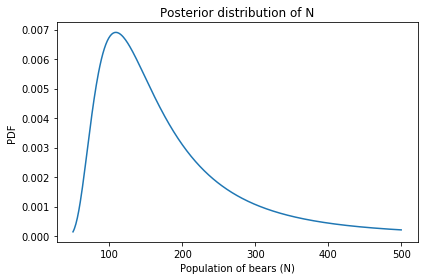

In [125]:
posterior_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior distribution of N')

The most likely value is 109.

In [126]:
posterior_N.max_prob()

109

But the distribution is skewed to the right, so the posterior mean is substantially higher.

In [127]:
posterior_N.mean()

173.79880627085643

And the credible interval is quite wide.

In [128]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

This solution is relatively simple, but it turn out we can do a little better if we model the unknown probability of observing a bear explicitly.

## Two parameter model

In this model there are two parameters: the number of bears, `N`, and the probability of observing a bear, `p`.

I'll assume that the probability is the same in both rounds, which is probably reasonable in this case because it is the same kind of trap in the same place.

I'll also assume that the probabilities are independent; that is, the probability a bear is observed in the second round does not depend on whether it was observed in the first round.  This second assumption might be less reasonable, but for now it is a necessary simplification.

Here are the counts again:

In [129]:
K = 23
n = 19
k = 4

For this model, I'll express the data in different notation: 

* `k10` is the number of bears observed in the first round but not the second,

* `k01` is the number of bears observed in the second round but not the first, and

* `k11` is the number of bears observed in both rounds.

Here are their values.

In [130]:
k10 = 23 - 4
k01 = 19 - 4
k11 = 4

Now, as an example, suppose we know the actual values of `N` and `p`.  We can use them to compute the likelihood of this data.

For example, if we know that `N=100`, we can compute `k00`, which is the number of unobserved bears.

In [131]:
N = 100

observed = k01 + k10 + k11
k00 = N - observed
k00

62

And we can represent the data as a list of counts.

In [132]:
x = [k00, k01, k10, k11]
x

[62, 15, 19, 4]

If we know `p=0.2`, we can compute the probability a bear falls in each category.  For example, the probability of being observed in both rounds is `p*p`, and the probability of being unobserved in both rounds is `q*q` (where `q=1-p`).

In [133]:
p = 0.2
q = 1-p
ps = [q*q, q*p, p*q, p*p]
ps

[0.6400000000000001,
 0.16000000000000003,
 0.16000000000000003,
 0.04000000000000001]

Now the probability of the data is given by the PMF of the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution):

$\mathrm{PMF}(x, n, p) = \frac{n!}{\prod x_i!} \prod p_i^{x_i} $

where $x$ is an array of counts, $n$ is the sum of the counts, and $p$ is an array of probabilities.

SciPy provides `multinomial`, which provides `pmf`, which computes this PMF.
Here is the probability of the data for these values of `N` and `p`.

In [134]:
from scipy.stats import multinomial

likelihood = multinomial.pmf(x, N, ps)
likelihood

0.0016664011988507257

Now we are ready to do a Bayesian update.
Here is a uniform prior for the number of bears, `N`:

In [135]:
Ns = np.arange(50, 501)
prior_N = Pmf(1.0, Ns)
prior_N.index.name = 'N'

And a uniform prior for the probability of observing a bear, `p`:

In [138]:
ps = np.linspace(0, 1, 100, endpoint=False)
prior_p = Pmf(1.0, ps)
prior_p.index.name = 'p'

We can make a joint distribution is the usual way.

In [139]:
from utils import make_joint

joint_prior = make_joint(prior_p, prior_N)
joint_prior.head(2)

p,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
N,,,,,,,,,,,,,,,,,,,,,
50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
51,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


The result is a Pandas `DataFrame` with value of `N` down the rows and values of `p` across the columns.
However, for this problem it will be convenient to represent the prior distribution as a 1-D `Series` rather than a 2-D `DataFrame`.
We can convert from one format to the other using `stack`.

In [140]:
joint_pmf = joint_prior.stack()
joint_pmf.head()

N   p   
50  0.00    1.0
    0.01    1.0
    0.02    1.0
    0.03    1.0
    0.04    1.0
dtype: float64

The result is a `Series` whose index is a `MultiIndex`.

In [141]:
type(joint_pmf)

pandas.core.series.Series

In [142]:
type(joint_pmf.index)

pandas.core.indexes.multi.MultiIndex

A `MultiIndex` can have more than one column; in this example, the first column contains values of `N` and the second column contains values of `p`.
The `Series` has one row (and one prior probability) for each possible pair of parameters `N` and `p`.
So the total number of rows is the product of the lengths of `prior_N` and `prior_p`.

In [143]:
joint_pmf.shape

(45100,)

Now we have to compute the likelihood of the data for each pair of parameters.
To allocate space for the likelihoods, it is convenient to make a copy of `joint_pmf`:

In [144]:
observed = k01 + k10 + k11
likelihood = joint_pmf.copy()

As we loop through the pairs of parameters, we compute the likelihood of the data as in the previous section, and then use `loc` to store the result as a row in `likelihood`.

In [145]:
for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1-p
    ps = [q*q, q*p, p*q, p*p]
    likelihood.loc[N, p] = multinomial.pmf(x, N, ps)

Now we can compute the posterior in the usual way.

In [146]:
posterior_pmf = joint_pmf * likelihood
normalize(posterior_pmf)

We can use `plot_contour` again to visualize the joint posterior distribution.

In [147]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

But remember that the posterior distribution we just computed is represented as a `Series`, and `plot_contour` expects a `DataFrame`.

Since we used `stack` to convert from a `DataFrame` to a `Series`, we can use `unstack` to go the other way.

In [155]:
joint_posterior = posterior_pmf.unstack()

And here's what the result looks like.

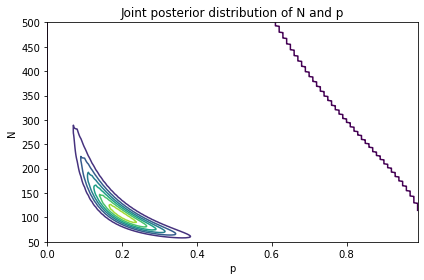

In [156]:
plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

Now that we have a posterior `DataFrame`, we can extract the marginal distributions in the usual way.

Here's the posterior distribution for `N`, compared to the posterior we got using the hypergeometric distribution.

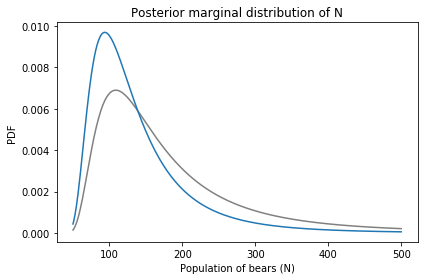

In [158]:
from utils import marginal

posterior2_N = marginal(joint_posterior, 1)

posterior_N.plot(color='gray')
posterior2_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

The mean is a little lower and the 90% credible interval is a little narrower.

In [159]:
posterior_N.mean(), posterior_N.credible_interval(0.9)

(173.79880627085643, array([ 77., 363.]))

In [151]:
posterior2_N.mean(), posterior2_N.credible_interval(0.9)

(138.75052136472598, array([ 68., 277.]))

And here's the posterior distribution for `p`:

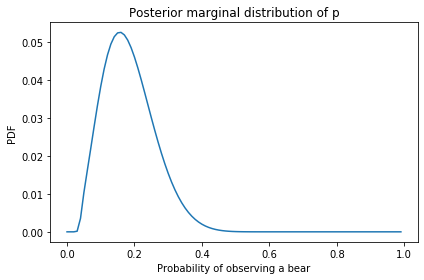

In [160]:
posterior2_p = marginal(joint_posterior, 0)
posterior2_p.plot()

decorate(xlabel='Probability of observing a bear',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

Seaborn provides a class called `JointGrid` that shows the joint distribution and marginal distributions in a single plot.

In [153]:
from seaborn import JointGrid

def joint_plot(joint, **options):
    x = joint.columns.name
    x = 'x' if x is None else x

    y = joint.index.name
    y = 'y' if y is None else y

    # make a JointGrid with minimal data
    data = pd.DataFrame({x:[0], y:[0]})
    g = JointGrid(x, y, data, **options)

    # replace the contour plot
    g.ax_joint.contour(joint.columns, 
                   joint.index, 
                   joint, 
                   cmap='viridis')
    
    # replace the marginals
    marginal_x = marginal(joint, 0)
    g.ax_marg_x.plot(marginal_x.qs, marginal_x.ps)
    
    marginal_y = marginal(joint, 1)
    g.ax_marg_y.plot(marginal_y.ps, marginal_y.qs)

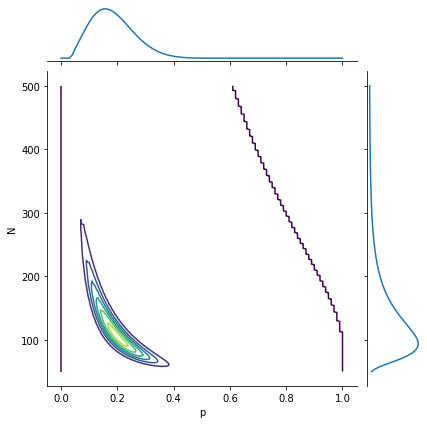

In [31]:
joint_plot(joint_posterior)

A `JointGrid` is a concise way to represent the results.  It also makes it clearer why marginal distributions are called "marginal".

## Two parameters better than one?

In [32]:
import warnings
warnings.filterwarnings("error")

In [33]:
mean = (23 + 19) / 2
N1 = 138
p = mean/N1
p

0.15217391304347827

In [34]:
from scipy.stats import binom

binom(N1, p).std()

4.219519857292647

In [35]:
binom(N1, p).pmf([23, 19]).prod()

0.007113233315460428

In [36]:
N2 = 173
p = mean/N2
p

0.12138728323699421

In [37]:
binom(N2, p).std()

4.2954472470306415

In [38]:
binom(N2, p).pmf([23, 19]).prod()

0.006918408214247037

## The Lincoln index problem

A few years ago my occasional correspondent John D. Cook wrote an excellent
blog post about the Lincoln index, which is a way to estimate the
number of errors in a document (or program) by comparing results from
two independent testers. 

http://www.johndcook.com/blog/2010/07/13/lincoln-index/

Here's his presentation of the problem:

>"Suppose you have a tester who finds 20 bugs in your program. You
want to estimate how many bugs are really in the program. You know
there are at least 20 bugs, and if you have supreme confidence in your
tester, you may suppose there are around 20 bugs. But maybe your
tester isn't very good. Maybe there are hundreds of bugs. How can you
have any idea how many bugs there are? There's no way to know with one
tester. But if you have two testers, you can get a good idea, even if
you don't know how skilled the testers are."

Suppose the first tester finds 20 bugs, the second finds 15, and they
find 3 in common; how can we estimate the number of bugs?

In [39]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In [40]:
data = np.array([0, k01, k10, k11])

In [41]:
p0, p1 = 0.2, 0.15

In [42]:
def compute_ps(p0, p1):
    q0 = 1-p0
    q1 = 1-p1
    return [q0*q1, q0*p1, p0*q1, p0*p1]

In [43]:
ps = compute_ps(p0, p1)
ps

[0.68, 0.12, 0.17, 0.03]

In [44]:
Ns = np.arange(32, 350)
prior_N = Pmf(1.0, Ns)
prior_N.index.name = 'N'

In [45]:
likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

for N in Ns:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, ps)

In [46]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.10960645032182426

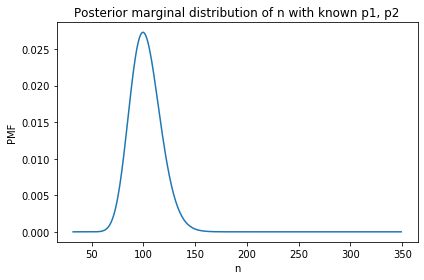

In [47]:
posterior_N.plot()

decorate(xlabel='n',
         ylabel='PMF',
         title='Posterior marginal distribution of n with known p1, p2')

In [48]:
posterior_N.mean()

102.12500000000006

## Unknown probabilities

In [49]:
Ns = np.arange(32, 350, 5)
prior_N = Pmf(1.0, Ns)
prior_N.index.name = 'N'

In [50]:
p0 = np.linspace(0, 1, 51)
prior_p0 = Pmf(1.0, p0)
prior_p0.index.name = 'p0'

In [51]:
p1 = np.linspace(0, 1, 51)
prior_p1 = Pmf(1.0, p1)
prior_p1.index.name = 'p1'

In [52]:
from utils import make_joint

joint2 = make_joint(prior_p0, prior_N)
joint2.shape

(64, 51)

In [53]:
joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head()

N   p0  
32  0.00    1.0
    0.02    1.0
    0.04    1.0
    0.06    1.0
    0.08    1.0
dtype: float64

In [54]:
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape

(3264, 51)

In [55]:
joint3.head()

p1       0.00  0.02  0.04  0.06  0.08  0.10  0.12  0.14  0.16  0.18  ...  \
N  p0                                                                ...   
32 0.00   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
   0.02   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
   0.04   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
   0.06   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
   0.08   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   

p1       0.82  0.84  0.86  0.88  0.90  0.92  0.94  0.96  0.98  1.00  
N  p0                                                                
32 0.00   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
   0.02   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
   0.04   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
   0.06   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
   0.08   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  

[5 rows x 51 columns]

In [56]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head()

N   p0   p1  
32  0.0  0.00    1.0
         0.02    1.0
         0.04    1.0
         0.06    1.0
         0.08    1.0
dtype: float64

In [57]:
joint3_pmf.shape

(166464,)

In [58]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    ps = compute_ps(p0, p1)
    likelihood.loc[N, p0, p1] = multinomial.pmf(x, N, ps)

In [59]:
from utils import normalize

joint_posterior = joint3_pmf * likelihood
normalize(joint_posterior)
joint_posterior.shape

(166464,)

In [60]:
# TODO: Add this to empiricaldist

def pmf_marginal(joint, level):
    """Compute a marginal distribution.
    
    joint: DataFrame representing a joint distribution
    level: int, level to sum along
    
    returns: Pmf
    """
    return Pmf(joint.sum(level=level))

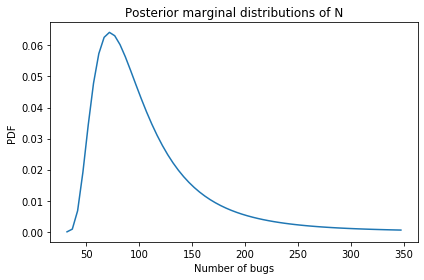

In [61]:
posterior_N = pmf_marginal(joint_posterior, 0)
posterior_N.plot()

decorate(xlabel='Number of bugs',
         ylabel='PDF',
         title='Posterior marginal distributions of N')

In [62]:
posterior_N.mean()

105.76561732196228

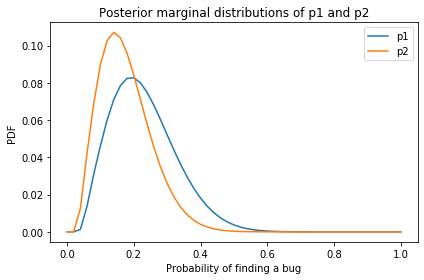

In [63]:
posterior_p1 = pmf_marginal(joint_posterior, 1)
posterior_p2 = pmf_marginal(joint_posterior, 2)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')
decorate(xlabel='Probability of finding a bug',
         ylabel='PDF',
         title='Posterior marginal distributions of p1 and p2')

In [64]:
posterior_p1.mean(), posterior_p1.credible_interval(0.9)

(0.22970659716777317, array([0.1, 0.4]))

In [65]:
posterior_p2.mean(), posterior_p2.credible_interval(0.9)

(0.1750117215592575, array([0.06, 0.32]))

## Hepatitis A

Chao et al, Table II, two rounds (P and Q)

In [66]:
data = np.array([0, 73, 86, 49])

In [67]:
Ns = np.arange(200, 500, 5)
prior_N = Pmf(1.0, Ns)
prior_N.index.name = 'N'

In [68]:
ps = np.linspace(0, 1, 50, endpoint=False)
prior_p = Pmf(1.0, ps)
prior_p.index.name = 'p'

In [69]:
from utils import make_joint

joint_prior = make_joint(prior_p, prior_N)
joint_prior.head(2)

p,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98
N,,,,,,,,,,,,,,,,,,,,,
200,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
205,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [70]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head()

N    p   
200  0.00    1.0
     0.02    1.0
     0.04    1.0
     0.06    1.0
     0.08    1.0
dtype: float64

In [71]:
observed = data.sum()
likelihood = joint_pmf.copy()
x = data.copy()

for N, p in joint_pmf.index:
    x[0] = N - observed
    q = 1-p
    ps = [q*q, q*p, p*q, p*p]
    likelihood.loc[N, p] = multinomial.pmf(x, N, ps)

In [72]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

0.0037986800467167204

In [73]:
joint_posterior = posterior_pmf.unstack()

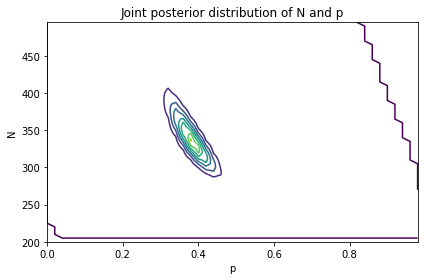

In [74]:
plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

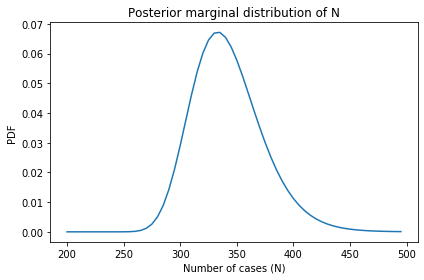

In [75]:
marginal_N = marginal(joint_posterior, 1)
marginal_N.plot()

decorate(xlabel='Number of cases (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [76]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(342.1317040018938, array([295., 400.]))

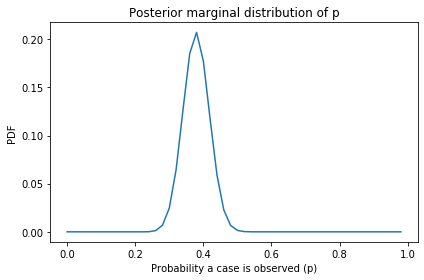

In [77]:
marginal_p = marginal(joint_posterior, 0)
marginal_p.plot()

decorate(xlabel='Probability a case is observed (p)',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

In [78]:
from seaborn import JointGrid

def joint_plot(joint, **options):
    x = joint.columns.name
    x = 'x' if x is None else x

    y = joint.index.name
    y = 'y' if y is None else y

    # make a JointGrid with minimal data
    data = pd.DataFrame({x:[0], y:[0]})
    g = JointGrid(x, y, data, **options)

    # replace the contour plot
    g.ax_joint.contour(joint.columns, 
                   joint.index, 
                   joint, 
                   cmap='viridis')
    
    # replace the marginals
    marginal_x = marginal(joint, 0)
    g.ax_marg_x.plot(marginal_x.qs, marginal_x.ps)
    
    marginal_y = marginal(joint, 1)
    g.ax_marg_y.plot(marginal_y.ps, marginal_y.qs)

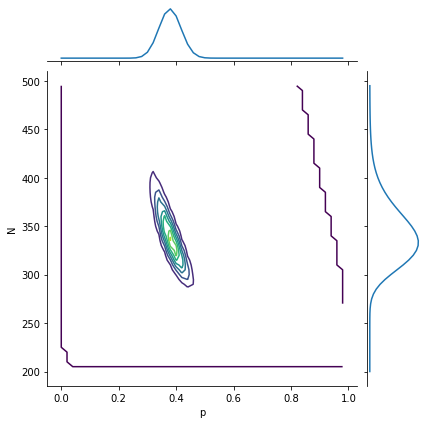

In [79]:
joint_plot(joint_posterior)

## Hep A, Three rounds

In [80]:
data = np.array([0, 63, 55, 18, 69, 17, 21, 28])

The following function is based on [this answer](https://stackoverflow.com/questions/58242078/cartesian-product-of-arbitrary-lists-in-pandas/58242079#58242079)

In [81]:
def cartesian_product(*args, **options):
    index = pd.MultiIndex.from_product(args, **options)
    return pd.DataFrame(index=index).reset_index()

In [82]:
p = 0.2
df = cartesian_product([1-p, p], [1-p, p], [1-p, p])
df

,level_0,level_1,level_2
0,0.8,0.8,0.8
1,0.8,0.8,0.2
2,0.8,0.2,0.8
3,0.8,0.2,0.2
4,0.2,0.8,0.8
5,0.2,0.8,0.2
6,0.2,0.2,0.8
7,0.2,0.2,0.2


In [83]:
ps = df.prod(axis=1)
ps

0    0.512
1    0.128
2    0.128
3    0.032
4    0.128
5    0.032
6    0.032
7    0.008
dtype: float64

In [84]:
observed = data.sum()
likelihood = joint_pmf.copy()
x = data.copy()

for N, p in joint_pmf.index:
    x[0] = N - observed
    df = cartesian_product([1-p, p], [1-p, p], [1-p, p])
    ps = df.prod(axis=1)
    likelihood.loc[N, p] = multinomial.pmf(x, N, ps)

In [85]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

7.907855348866113e-13

In [86]:
joint_posterior = posterior_pmf.unstack()

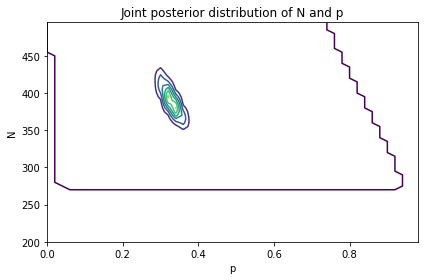

In [87]:
plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

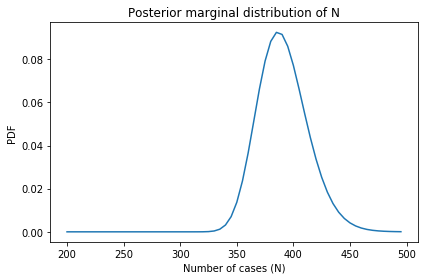

In [88]:
marginal_N = marginal(joint_posterior, 1)
marginal_N.plot()

decorate(xlabel='Number of cases (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [89]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(391.00501407503725, array([360., 430.]))

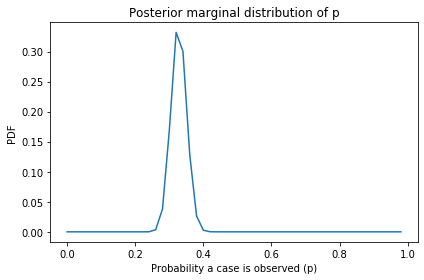

In [90]:
marginal_p = marginal(joint_posterior, 0)
marginal_p.plot()

decorate(xlabel='Probability a case is observed (p)',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

In [91]:
from seaborn import JointGrid

def joint_plot(joint, **options):
    x = joint.columns.name
    x = 'x' if x is None else x

    y = joint.index.name
    y = 'y' if y is None else y

    # make a JointGrid with minimal data
    data = pd.DataFrame({x:[0], y:[0]})
    g = JointGrid(x, y, data, **options)

    # replace the contour plot
    g.ax_joint.contour(joint.columns, 
                   joint.index, 
                   joint, 
                   cmap='viridis')
    
    # replace the marginals
    marginal_x = marginal(joint, 0)
    g.ax_marg_x.plot(marginal_x.qs, marginal_x.ps)
    
    marginal_y = marginal(joint, 1)
    g.ax_marg_y.plot(marginal_y.ps, marginal_y.qs)

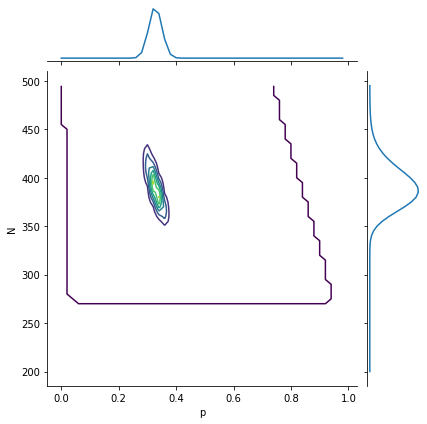

In [92]:
joint_plot(joint_posterior)